<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/time_series_forecasting/4_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*#author: Caroline Jungheim*

For task 3 we need to extract both variables (temp, o3) from the past and extract only temp from the future. After this we have to concatenate both.

For task 3 I will mark lines which I changed in contrast to task 2 with an extra emoji 🐬

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import os

context_window = 336
prediction_horizon = 96

#🦋 Add both variables temperature and ozone data
variable_column = ["temp", "o3"]
#🦋 Specify target variable
target_variable = ["o3"]

In [22]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

## Download the .pkl files from drive

In [23]:
#🦋 Get Google Drive Path
from google.colab import drive
drive.mount('/content/drive')
BASEPATH = '/content/drive/MyDrive'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
#🦋 Get data from saved csv
dataframe = pd.read_csv(os.path.join(BASEPATH + "/content/timeseries_data", "normalized_data.csv"))

dataframe.head()

,longitude,latitude,station_code,datetime,o3,no2,no,temp,press
0,6.093923,50.754704,DENW094,1997-01-01 00:00:00+00:00,-1.686509,-2.140763,-0.758096,-3.566220,-337.675195
1,6.093923,50.754704,DENW094,1997-01-01 01:00:00+00:00,-1.686509,-2.140763,-0.758096,-3.633418,-337.675195
2,6.093923,50.754704,DENW094,1997-01-01 02:00:00+00:00,-1.686509,-2.140763,-0.758096,-3.646857,-337.675195
3,6.093923,50.754704,DENW094,1997-01-01 03:00:00+00:00,-1.686509,-2.140763,-0.758096,-3.740934,-337.675195
4,6.093923,50.754704,DENW094,1997-01-01 04:00:00+00:00,-1.686509,-2.140763,-0.758096,-3.767813,-337.675195


In [25]:
dataframe = dataframe.drop(columns=["no2","no","press"])
dataframe.head()

,longitude,latitude,station_code,datetime,o3,temp
0,6.093923,50.754704,DENW094,1997-01-01 00:00:00+00:00,-1.686509,-3.566220
1,6.093923,50.754704,DENW094,1997-01-01 01:00:00+00:00,-1.686509,-3.633418
2,6.093923,50.754704,DENW094,1997-01-01 02:00:00+00:00,-1.686509,-3.646857
3,6.093923,50.754704,DENW094,1997-01-01 03:00:00+00:00,-1.686509,-3.740934
4,6.093923,50.754704,DENW094,1997-01-01 04:00:00+00:00,-1.686509,-3.767813


In [26]:
#🦋 Remove duplicates -> aggregate them with mean
df_no_dups = dataframe.groupby(['station_code', 'datetime']).mean().reset_index()


In [27]:
df_no_dups.shape

(148435, 6)

# Data Preparation like in second notebook


In [28]:
#🦋 Copied code from notebook 3
# Function to create continous time-series data with past 24 hours as input and next 6 hours as output
def create_sequences(data, variable_column, n_past=336, n_future=96):
    df = data.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values(['station_code', 'datetime']).reset_index(drop=True)

    # 1) Encode station_code as a small integer (categorical codes) to save memory
    df['sc_code'] = df['station_code'].astype('category')

    # 2) Boolean mask: True if exactly 1 hour after the previous row (per station)
    is1h = (
        df.groupby('station_code')['datetime']
          .diff()
          .eq(pd.Timedelta(hours=1))
    )

    # 3) Compute how many consecutive “True” over (n_past + n_future - 1) rows
    gap_window = n_past + n_future - 1
    run = (
        is1h.groupby(df['station_code'])
            .rolling(window=gap_window, min_periods=gap_window)
            .sum()
            .reset_index(level=0, drop=True)
    )

    # 4) 'ends' are indices where run == gap_window (end of a full-length continuous block)
    ends = run[run == gap_window].index

    # 5) Grab column‐arrays for encoded station code and the variable
    sc_arr  = df['sc_code'].values
    vals    = df[variable_column].values

    X_list = []
    y_list = []
    for end_idx in ends:
        start_idx = end_idx - gap_window
        if start_idx >= 0 and sc_arr[start_idx] == sc_arr[end_idx]:
            station_block = sc_arr[start_idx : end_idx + 1]
            var_block     = vals[start_idx : end_idx + 1]

            block = np.column_stack((station_block, var_block))

            X_list.append(block[:n_past, :])
            y_list.append(block[n_past:, :])

    if not X_list:
        # No valid windows
        return np.empty((0, n_past, 2)), np.empty((0, n_future, 2))

    X = np.stack(X_list)  # shape = (num_windows, n_past, 2)
    y = np.stack(y_list)  # shape = (num_windows, n_future, 2)
    return X, y

In [29]:
#🦋 Copied code from notebook 3
context_window = 336
prediction_horizon = 96

X, y = create_sequences(df_no_dups,variable_column, context_window,prediction_horizon)

train_size = int(len(X) * 0.7)
X_train_full, X_test_full = X[:train_size], X[train_size:]
y_train_full, y_test_full = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train_full.shape}, y_train shape: {y_train_full.shape}")
print(f"X_test shape: {X_test_full.shape}, y_test shape: {y_test_full.shape}")

X_train shape: (21493, 336, 3), y_train shape: (21493, 96, 3)
X_test shape: (9212, 336, 3), y_test shape: (9212, 96, 3)


## Model for Task 2

In [30]:
#🦋 Change test and train sets so only temp and o3 is input and not station id and only o3 is output

X_train_o3 = X_train_full[:,:,1:].copy()
X_test_o3 = X_test_full[:,:,1:].copy()
y_train_o3 = y_train_full[:,:,2].copy()
y_test_o3 = y_test_full[:,:,2].copy()

# Flatten input features
X_train = X_train_o3.reshape(X_train_o3.shape[0], X_train_o3.shape[1], len(variable_column))
y_train = y_train_o3.reshape(y_train_o3.shape[0], y_train_o3.shape[1],  len(target_variable))
X_test = X_test_o3.reshape(X_test_o3.shape[0], X_test_o3.shape[1],  len(variable_column))
y_test = y_test_o3.reshape(y_test_o3.shape[0], y_test_o3.shape[1],   len(target_variable))

X_train = np.array(X_train, dtype=np.float32)
X_test  = np.array(X_test,  dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test  = np.array(y_test,  dtype=np.float32)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (21493, 336, 2), y_train shape: (21493, 96, 1)
X_test shape: (9212, 336, 2), y_test shape: (9212, 96, 1)


In [31]:
#🦋Flatten because now we habe more variables and we need this for training
# Flatten Input: (samples, context_window, num_features) -> (samples, context_window * num_features)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Flatten Output: (samples, pred_horizon, num_target_features) -> (samples, pred_horizon * num_target_features)
y_train_flat = y_train.reshape(y_train.shape[0], -1)
y_test_flat = y_test.reshape(y_test.shape[0], -1)

print(f"X_train shape: {X_train_flat.shape}, y_train shape: {y_train_flat.shape}")
print(f"X_test shape: {X_test_flat.shape}, y_test shape: {y_test_flat.shape}")

X_train shape: (21493, 672), y_train shape: (21493, 96)
X_test shape: (9212, 672), y_test shape: (9212, 96)


In [32]:
## Remember the checkpoints made available are trained with below hyper params
# If changed you will have to retrain loading appropriate inputs like eg. loss
mlp_hidden_units = [64, 32]
mlp_epochs = 5
mlp_batch_size = 16
activation_fn='relu'
mlp_optim = 'adam'
mlp_loss = 'mse'

In [34]:
#🦋 Removed checkpoint and adapt code
num_variables = 1 #len(target_column)
mlp_predictions = []
training_histories = {}

for var_idx in range(num_variables):
  print(f"Training new model for variable {var_idx + 1}")

  # Build MLP model
  mlp_model = Sequential([
      Input(shape=(X_train_flat.shape[1],)),  # 24 timesteps (context window)
      Dense(mlp_hidden_units[0], activation=activation_fn)
  ])

  for units in mlp_hidden_units[1:]:
      mlp_model.add(Dense(units, activation=activation_fn))

  mlp_model.add(Dense(y_train_flat.shape[1]))  # 6 timesteps (pred horizon)
  mlp_model.compile(optimizer=mlp_optim, loss=mlp_loss)

  # Train model
  training = mlp_model.fit(
      X_train_flat, y_train_flat,
      epochs=mlp_epochs, batch_size=mlp_batch_size,
      validation_split=0.2, verbose=1
  )
  training_histories[var_idx] = training.history

y_pred_single = mlp_model.predict(X_test_flat.astype(np.float32))
mlp_predictions.append(y_pred_single)

mlp_predictions = np.concatenate(mlp_predictions, axis=-1).reshape(y_test.shape[0], prediction_horizon, num_variables)  # Shape: (samples, pred hor, 5)
y_pred_single = y_pred_single.reshape(y_pred_single.shape[0], prediction_horizon, 1)

Training new model for variable 1
Epoch 1/5
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.7098 - val_loss: 0.5734
Epoch 2/5
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4952 - val_loss: 0.6302
Epoch 3/5
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4343 - val_loss: 0.6098
Epoch 4/5
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3963 - val_loss: 0.6335
Epoch 5/5
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3703 - val_loss: 0.6331
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


## Model for Task 3

In [35]:
#🦋 Change test and train sets so only temp and o3 is input and not station id and only o3 is output

#🐬Extract past data -> Only renamed variable
X_train_past = X_train_full[:,:,1:].copy()
X_test_past = X_test_full[:,:,1:].copy()

#🐬Extract future temperature data from y
temp_future = y_train_full[:, :, 1][..., np.newaxis]
temp_future_test = y_test_full[:, :, 1][..., np.newaxis]

#🐬 Fix shape mismatch by padding temp_future to 2 features (temp + dummy o3)
# Shape (samples, 96, 1) → (samples, 96, 2)
dummy_o3 = np.zeros_like(temp_future)
temp_future_padded = np.concatenate([temp_future, dummy_o3], axis=2)

dummy_o3_test = np.zeros_like(temp_future_test)
temp_future_test_padded = np.concatenate([temp_future_test, dummy_o3_test], axis=2)


#🐬Combine both past and future
X_train_both = np.concatenate([X_train_past, temp_future_padded], axis=1)
X_test_both = np.concatenate([X_test_past, temp_future_test_padded], axis=1)

# Target variabled
y_train_both = y_train_full[:,:,2].copy()
y_test_both = y_test_full[:,:,2].copy()

X_train_task3 = np.array(X_train_both, dtype=np.float32)
X_test_task3  = np.array(X_test_both,  dtype=np.float32)
y_train_task3 = np.array(y_train_both, dtype=np.float32)
y_test_task3  = np.array(y_test_both,  dtype=np.float32)

print(f"X_train shape: {X_train_task3.shape}, y_train shape: {y_train_task3.shape}")
print(f"X_test shape: {X_test_task3.shape}, y_test shape: {y_test_task3.shape}")

X_train shape: (21493, 432, 2), y_train shape: (21493, 96)
X_test shape: (9212, 432, 2), y_test shape: (9212, 96)


In [36]:
#🦋Flatten because now we habe more variables and we need this for training
# Flatten Input: (samples, context_window, num_features) -> (samples, context_window * num_features)
X_train_flat_task3 = X_train_task3.reshape(X_train_task3.shape[0], -1)
X_test_flat_task3 = X_test_task3.reshape(X_test_task3.shape[0], -1)

# Flatten Output: (samples, pred_horizon, num_target_features) -> (samples, pred_horizon * num_target_features)
y_train_flat_task3 = y_train_task3.reshape(y_train_task3.shape[0], -1)
y_test_flat_task3 = y_test_task3.reshape(y_test_task3.shape[0], -1)

print(f"X_train shape: {X_train_flat_task3.shape}, y_train shape: {y_train_flat_task3.shape}")
print(f"X_test shape: {X_test_flat_task3.shape}, y_test shape: {y_test_flat_task3.shape}")

X_train shape: (21493, 864), y_train shape: (21493, 96)
X_test shape: (9212, 864), y_test shape: (9212, 96)


### Forecasting with Simple Neural Network: MLP

> The below snippet uses tensorflow to create a simple

😈 **Task 2:** Try changing the number of input lags used. How does it affect forecasting accuracy?

😈 **Task 3:** Compare results using `no2` vs `o3` as the target variable.


The below cell has sample hyperparameters and activation, loss functions, Modify these values for experimentation


😈 **Task 4:** Modify the activation function to `tanh` or `selu`. How does training performance change?

😈 **Task 5:** Try different optimizers (e.g., SGD, RMSProp) and compare their impact on convergence.

😈 **Question 2:** Why might ReLU not be ideal for all types of time series data?

In [37]:
## Remember the checkpoints made available are trained with below hyper params
# If changed you will have to retrain loading appropriate inputs like eg. loss
mlp_hidden_units = [64, 32]
mlp_epochs = 5
mlp_batch_size = 16
activation_fn='relu'
mlp_optim = 'adam'
mlp_loss = 'mse'

In [38]:
#🦋🐬 Removed checkpoint and adapt code
num_variables = 1 #len(target_column)
mlp_predictions_task3 = []
training_histories_task3 = {}

for var_idx in range(num_variables):
  print(f"Training new model for variable {var_idx + 1}")

  # Build MLP model
  mlp_model_task3 = Sequential([
      Input(shape=(X_train_flat_task3.shape[1],)),  # 24 timesteps (context window)
      Dense(mlp_hidden_units[0], activation=activation_fn)
  ])

  for units in mlp_hidden_units[1:]:
      mlp_model_task3.add(Dense(units, activation=activation_fn))

  mlp_model_task3.add(Dense(y_train_flat_task3.shape[1]))  # 6 timesteps (pred horizon)
  mlp_model_task3.compile(optimizer=mlp_optim, loss=mlp_loss)

  # Train model
  training_task3 = mlp_model_task3.fit(
      X_train_flat_task3, y_train_flat_task3,
      epochs=mlp_epochs, batch_size=mlp_batch_size,
      validation_split=0.2, verbose=1
  )
  training_histories_task3[var_idx] = training.history

y_pred_single_task3 = mlp_model_task3.predict(X_test_flat_task3.astype(np.float32))
mlp_predictions_task3.append(y_pred_single_task3)

mlp_predictions_task3 = np.concatenate(mlp_predictions_task3, axis=-1).reshape(y_test_task3.shape[0], prediction_horizon, num_variables)  # Shape: (samples, pred hor, 5)
y_pred_single_task3 = y_pred_single_task3.reshape(y_pred_single_task3.shape[0], prediction_horizon, 1)


Training new model for variable 1
Epoch 1/5
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6298 - val_loss: 0.5285
Epoch 2/5
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3735 - val_loss: 0.5288
Epoch 3/5
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3236 - val_loss: 0.5196
Epoch 4/5
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3005 - val_loss: 0.5034
Epoch 5/5
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2863 - val_loss: 0.5112
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


# Compare Task 2 and 3

In [39]:
# Evaluate
y_test_reshaped = y_test.reshape(y_test.shape[0], prediction_horizon, num_variables) ## depending on
y_test = y_test_reshaped[:, :, var_idx]
y_pred = mlp_predictions[:, :, var_idx]

#🐬
y_test_reshaped_task3 = y_test_task3.reshape(y_test_task3.shape[0], prediction_horizon, num_variables) ## depending on
y_test_task3 = y_test_reshaped_task3[:, :, var_idx]
y_pred_task3 = mlp_predictions_task3[:, :, var_idx]

#🐬 Evaluate the model for this variable
print("Task 2:")
evaluate_model(y_test, y_pred)
print("Task 3:")
evaluate_model(y_test_task3, y_pred_task3)

Task 2:
RMSE: 0.7657
Task 3:
RMSE: 0.6681


np.float64(0.6681141834436164)

In [65]:
#🐬 Took this function from notebook 7 and updated it
def plot_forecast_curves(X_sample, Y_sample, forecasts, context_window, prediction_horizon):
    """
    Plots multiple forecast curves from uploaded CSVs

    Parameters:
    - X_sample: The past data
    - Y_sample: The true future values
    - forecasts: Dictionary of all forecast which should be plotted
    - context_window: Number of time steps before forecast
    - prediction_horizon: Number of future time steps
    """
    plt.figure(figsize=(16, 10))

    plt.plot(range(context_window), X_sample, label="Context", color="blue", marker="o")
    plt.plot(range(context_window, context_window + prediction_horizon), Y_sample, label="Actual Future", color="green", marker="o")

    for model, values in forecasts.items():
      plt.plot(range(context_window, context_window + prediction_horizon), values, label=f"{model} Prediction", linestyle="--", marker="x")


    plt.title("Forecast Comparison")
    plt.xlabel("Time Step")
    plt.ylabel("o3")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [60]:
#Predict Task 2

# First sample of DENW094 station to compare with PatchTST
X_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == 'DENW094')[0]
X_test_sample = X_test_full[X_first_idx, :, 1:3]  # Spalten 1 und 2: temp + o3
X_test_sample_flat = X_test_sample.reshape(1, -1).astype(np.float32)
# First sample of DENW094 station to compare with PatchTST
y_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == 'DENW094')[0]
y_test_sample=y_test_full[y_first_idx, :, 1] # First column is station code hence adding 1

# Predict
mlp_pred_sample = mlp_model.predict(X_test_sample_flat).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [54]:
#🐬Predict Task 3

# First sample of DENW094 station to compare with PatchTST
X_first_idx_task3 = np.flatnonzero(X_test_full[:, 0, 0] == 'DENW094')[0]
X_test_sample_flat_task3 = X_test_flat_task3[X_first_idx_task3].reshape(1, -1).astype(np.float32)
# First sample of DENW094 station to compare with PatchTST
y_test_sample_task3 = y_test_flat_task3[X_first_idx_task3]

# Predict
mlp_pred_sample_task3 = mlp_model_task3.predict(X_test_sample_flat_task3).flatten()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [55]:
#🐬 Put both forecasts together in one dictionary
forecasts = {
    "MLP_Task2": mlp_pred_sample,
    "MLP_Task3": mlp_pred_sample_task3,
}

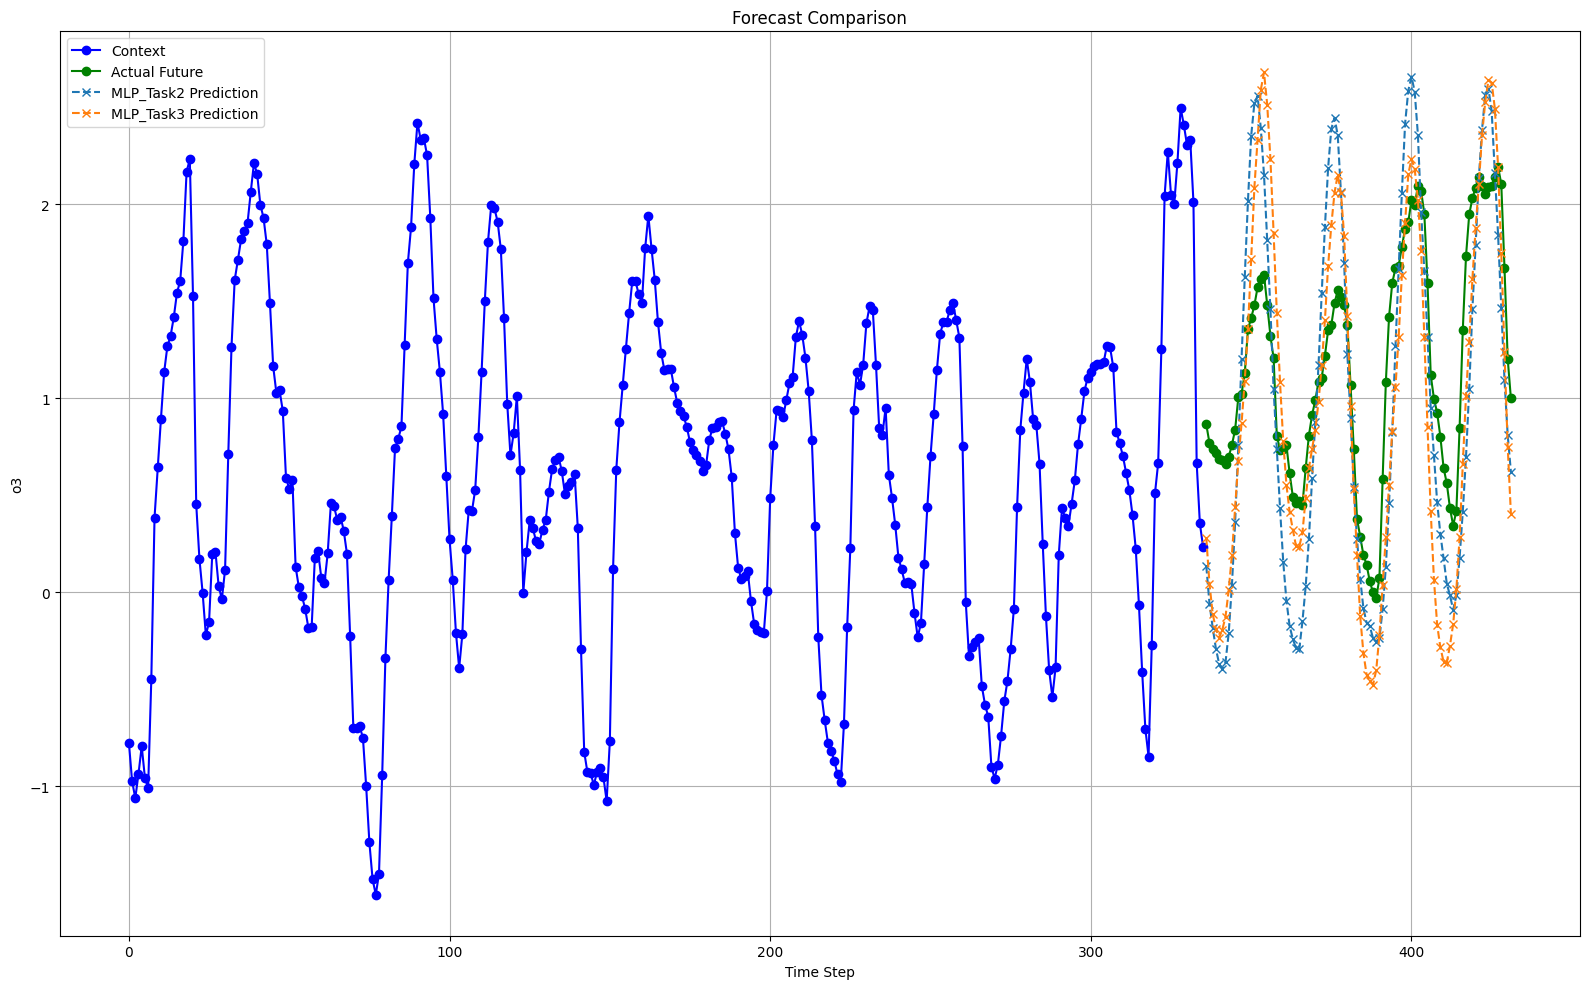

In [67]:
#🐬 Plot both tasks
plot_forecast_curves(X_test_sample[:, 1], y_test_sample, forecasts, 336, 96)

# Conclusion

In this experiment, we compared two forecasting setups for ozone (O3) prediction.
Task 2 used only past temperature and O₃ values, while Task 3 included additional future temperature data as input.
The goal was to assess whether providing known future temperature improves O3 prediction accuracy.
Evaluation results show that Task 3 achieved a lower RMSE (0.668) compared to Task 2 (0.7657).
This indicates that including future temperature enhances the model’s ability to predict O3 concentrations.
The visual comparison of forecasts confirmed this in a light way, with Task 3 predictions aligning a little bit more closely to the ground truth. Even if the difference is not very big, which can also be seen in the RMSE.
This result supports the hypothesis that partial future knowledge can improve forecast quality.
However, this assumes future temperature is known or accurately predicted in advance.  
A visible deviation was observed between the last context value and the start of the actual future curve. The forecast curves fit better to the context because the models has been trained on past data, it tends to continue the trend from the past context.